## 3D Reconstruction Via Volumetric Reconstruction

In [142]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D
import os


# Camera Calibration 
## Method
### Zhang's Method for Camera Calibration

Zhang’s method, developed by Zhengyou Zhang, is an efficient technique for calibrating a camera using a flat calibration object, such as a checkerboard pattern. This method is popular due to its simplicity, accuracy, and the fact that it does not require complex 3D objects or specialized equipment. Instead, it relies on capturing multiple images of a planar pattern from various orientations, making it widely applicable in real-world scenarios.

\subsection*{1. Mathematical Model of the Camera}

In Zhang’s approach, the camera model is decomposed into intrinsic and extrinsic parameters:
- \textbf{Intrinsic Parameters} define the camera's internal characteristics:
  
  $$
  \mathbf{K} = \begin{bmatrix} f_x & s & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}
  $$

  where:
  - $f_x$ and $f_y$ are the focal lengths in pixels,
  - $(c_x, c_y)$ is the principal point, and
  - $s$ is the skew coefficient (often close to zero for most cameras).
  
- \textbf{Extrinsic Parameters} describe the rotation and translation between the camera and the world coordinate system:

  $$
  \mathbf{P} = \mathbf{K} [\mathbf{R} \,|\, \mathbf{t}]
  $$

  where $\mathbf{R}$ is the rotation matrix and $\mathbf{t}$ is the translation vector.

\subsection*{2. Homography-Based Initial Estimation}

For each view of the checkerboard, the 3D world coordinates $(X_w, Y_w, 0)$ reduce to 2D coordinates on the plane. The relationship between the world points $\mathbf{X}_w = (X_w, Y_w, 1)^T$ and the corresponding 2D image points $\mathbf{x} = (x, y, 1)^T$ is captured by a \textbf{homography matrix} $\mathbf{H}$ such that:

$$
\mathbf{x} = \mathbf{H} \mathbf{X}_w
$$

For each view, the homography $\mathbf{H}$ relates the planar world coordinates to the 2D image coordinates and can be expressed as:

$$
\mathbf{H} = \mathbf{K} [\mathbf{r}_1 \, \mathbf{r}_2 \, \mathbf{t}]
$$

where $\mathbf{r}_1$ and $\mathbf{r}_2$ are the first two columns of the rotation matrix $\mathbf{R}$. Given that $\mathbf{r}_1$ and $\mathbf{r}_2$ are orthogonal unit vectors, we derive the following constraints:

$$
\mathbf{h}_1^T \mathbf{K}^{-T} \mathbf{K}^{-1} \mathbf{h}_2 = 0
$$
$$
\mathbf{h}_1^T \mathbf{K}^{-T} \mathbf{K}^{-1} \mathbf{h}_1 = \mathbf{h}_2^T \mathbf{K}^{-T} \mathbf{K}^{-1} \mathbf{h}_2
$$

where $\mathbf{h}_1$ and $\mathbf{h}_2$ are the columns of $\mathbf{H}$. By accumulating these constraints across multiple views of the calibration pattern, we obtain a system of linear equations.

\subsection*{3. Estimating the Intrinsic Matrix $\mathbf{K}$}

With at least three views of the pattern, we form a matrix system:

$$
\mathbf{V} \mathbf{b} = 0
$$

where $\mathbf{V}$ is a matrix built from the constraints, and $\mathbf{b}$ is a vector representing elements of $\mathbf{K}^{-T} \mathbf{K}^{-1}$. Solving for $\mathbf{b}$ yields an estimate for the intrinsic matrix $\mathbf{K}$, from which the intrinsic parameters $f_x$, $f_y$, $s$, $c_x$, and $c_y$ can be extracted.

\subsection*{4. Determining Extrinsic Parameters}

Once $\mathbf{K}$ is estimated, each homography matrix $\mathbf{H}$ provides the extrinsic parameters $\mathbf{R}$ and $\mathbf{t}$ for that view as follows:

$$
\mathbf{r}_1 = \lambda \mathbf{K}^{-1} \mathbf{h}_1, \quad \mathbf{r}_2 = \lambda \mathbf{K}^{-1} \mathbf{h}_2, \quad \mathbf{t} = \lambda \mathbf{K}^{-1} \mathbf{h}_3
$$

where $\lambda$ is a scaling factor, and $\mathbf{h}_1, \mathbf{h}_2, \mathbf{h}_3$ are the columns of $\mathbf{H}$. The rotation matrix $\mathbf{R}$ is obtained by orthonormalizing $\mathbf{r}_1$ and $\mathbf{r}_2$.

## Advantages of using cheaker board pattern

1. High contrast between black and white squares allows for precise corner detection.
2. Well-defined square corners enable subpixel accuracy in locating key points.
3. Simple 2D planar structure reduces model complexity and simplifies homography calculations.
4. Easily available and reproducible, making calibration setup convenient.
5. Portable, allowing capture from multiple views to improve calibration robustness.





In [143]:
# def calibrate_camera(calibration_dir_path):
#     """
#     Calibrates the camera using chessboard images from the specified directory.
    
#     Parameters:
#         calibration_dir_path (str): Path to the directory containing chessboard images.
    
#     Returns:
#         tuple: Camera intrinsic matrix (K), Distortion coefficients (dist), New undistorted camera matrix (K_undist)
#                (Returns None, None, None if calibration fails)
#     """
#     # Fetch all images
#     calibration_images = glob.glob(calibration_dir_path)

#     # Chessboard dimensions
#     chessboard_size = (8, 6)
#     # Criteria for corner refinement
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 24, 0.001)

#     # Prepare object points
#     objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
#     objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

#     # Arrays to store object points and image points
#     objpoints, imgpoints = [], []
#     gray, w, h = None, None, None

#     # Process each image
#     for i, fname in enumerate(calibration_images, start=1):
#         img = cv2.imread(fname)
#         if img is None:
#             print(f"Warning: Could not read image {fname}. Skipping.")
#             continue
        
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         h, w = img.shape[:2]

#         # Find chessboard corners
#         ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

#         if ret:
#             objpoints.append(objp)
#             corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
#             imgpoints.append(corners2)

#             # Draw and display the corners
#             img_with_corners = cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
#             img_with_corners_rgb = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
#             plt.figure(figsize=(8, 6))
#             plt.imshow(img_with_corners_rgb)
#             plt.title(f"Chessboard Corners (Image {i})")
#             plt.axis('off')
#             plt.show()
    
#     # Calibrate the camera
#     if objpoints and imgpoints:
#         ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#         print("Camera Intrinsic Matrix (K):\n", K)
#         print("\nDistortion Coefficients:\n", dist.ravel())
#         K_undist, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))
#         print("\nNew Undistorted Camera Matrix:\n", K_undist)
#         return K, dist, K_undist
#     else:
#         print("\nNo chessboard corners were detected in the images. Calibration failed.")
#         return None, None, None

# # --------------------------------------------------------------------------
# # Call the function as you did before (simple)

# # calibration_dir = r'F:\Final Year Project\FYP-3\Cheaker board pattern\Test\*.png'
# calibration_dir=r'F:\Final Year Project\FYP-3\Images\cal1\*.png'
# # calibration_dir = r'F:\Final Year Project\FYP-3\Cheaker board pattern\pi2\*.jpg'

# image_paths = glob.glob(calibration_dir)
# num_images = len(image_paths)

# print(f"Number of images in folder: {num_images}")


# K, dist, K_undist = calibrate_camera(calibration_dir)

# # Optional check if calibration failed
# if K is None:
#     print("\n❌ Camera calibration was unsuccessful. Please check the images or the chessboard size.")

## Uncalibrated Image 

1. Capture images for calibration. Use a calibration pattern (like a checkerboard) and capture multiple images from different angles.

2. Detect calibration points. Use image processing to find the corners of the checkerboard pattern and record the pixel coordinates $(u, v)$.

3. Define world coordinates. Set the 3D world coordinates for the detected points in the checkerboard pattern as:
   $$
   (X, Y, Z) = (x \cdot d, y \cdot d, 0)
   $$
   where $d$ is the size of each square and $(x, y)$ are the indices.

4. Estimate distortion coefficients. Use a calibration algorithm (like Zhang's method) to estimate the camera's intrinsic parameters $\mathbf{K}$ and distortion coefficients $(k_1, k_2, p_1, p_2, k_3)$.

5. Undistort the images. For each image, apply the distortion model:
   $$
   x_u = x_d (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + (2 p_1 x_d y_d + p_2 (r^2 + 2 x_d^2))
   $$
   $$
   y_u = y_d (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) + (p_1 (r^2 + 2 y_d^2) + 2 p_2 x_d y_d)
   $$

6. Re-estimate intrinsic parameters. Repeat the calibration process using the undistorted images to update the intrinsic matrix $\mathbf{K}'$ and distortion coefficients.

7. Formulate the new calibration matrix. The updated intrinsic camera matrix $\mathbf{K}'$ is:
   $$
   \mathbf{K}' = \begin{bmatrix} 
   f_x' & s' & c_x' \\ 
   0 & f_y' & c_y' \\ 
   0 & 0 & 1 
   \end{bmatrix}
   $$

8. Validate calibration. Compare reprojected points with original detected points and calculate the reprojection error.

9. Apply to future images. Use the updated intrinsic matrix $\mathbf{K}'$ and distortion coefficients for subsequent tasks.


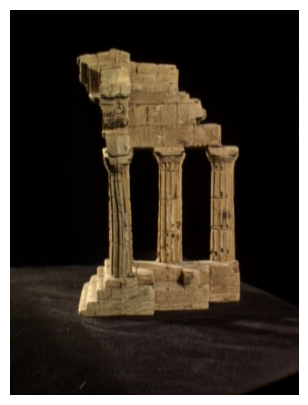

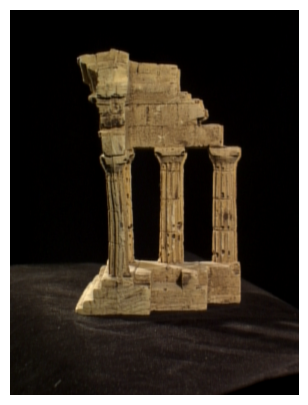

In [144]:
# Load stereo images
left_image = cv2.imread(r'F:\Final Year Project\FYP-3\Datasets\Lib\left8.png')
right_image = cv2.imread(r'F:\Final Year Project\FYP-3\Datasets\Lib\right8.png')

# Convert to grayscale
left_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

# (Optional) Undistortion placeholders
undistorted_left = left_image
undistorted_right = right_image
gray_undistorted_left = left_gray
gray_undistorted_right = right_gray

# Save raw undistorted images using OpenCV
cv2.imwrite(r'F:\Final Year Project\FYP-2\Tasks\6. 3D recinstruction via disperity map\6) 3D reconstruction via disparity\results\undistrorted_left2.jpg', undistorted_left)
cv2.imwrite(r'F:\Final Year Project\FYP-2\Tasks\6. 3D recinstruction via disperity map\6) 3D reconstruction via disparity\results\undistrorted_right2.jpg', undistorted_right)

# Save and show clean matplotlib figure of left image
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(undistorted_left, cv2.COLOR_BGR2RGB))
plt.axis('off')
# plt.savefig(r'F:\Final Year Project\FYP-2\Tasks\6. 3D recinstruction via disperity map\6) 3D reconstruction via disparity\results\undistorted_left_fig.png', bbox_inches='tight', pad_inches=0)
plt.show()

# Save and show clean matplotlib figure of right image
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(undistorted_right, cv2.COLOR_BGR2RGB))
plt.axis('off')
# plt.savefig(r'F:\Final Year Project\FYP-2\Tasks\6. 3D recinstruction via disperity map\6) 3D reconstruction via disparity\results\undistorted_right_fig.png', bbox_inches='tight', pad_inches=0)
plt.show()

# SIFT

In [145]:
def sift_feature_detector(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

# FLANN

In [146]:
def match_flann(descriptors1, descriptors2):
    """
    Perform feature matching using FLANN-based matcher.
    """
    index_params = dict(algorithm=1, trees=5)  # FLANN with KDTree for SIFT/SURF
    search_params = dict(checks=50)  # Number of times the tree is recursively traversed

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches_12 = flann.knnMatch(descriptors1, descriptors2, k=2)  # Match from img1 to img2
    matches_21 = flann.knnMatch(descriptors2, descriptors1, k=2)  # Match from img2 to img1
    return matches_12, matches_21



In [147]:
def filter_matches(matches_12, matches_21):
    """
    Apply the 1NN/2NN ratio test and perform cross-validation.
    """
    good_matches = []
    
    for m, n in matches_12:
        if m.distance < 0.75 * n.distance:  # Apply ratio test
            query_idx = m.queryIdx
            train_idx = m.trainIdx
            
            # Perform cross-validation check (reverse matching)
            reverse_matches = [rm for rm, rn in matches_21 if rm.queryIdx == train_idx and rm.trainIdx == query_idx]
            if reverse_matches:
                good_matches.append(m)
    
    return good_matches

In [148]:
def extract_matched_points(keypoints1, keypoints2, matches):
    """
    Extract matched keypoints from the images based on matches.
    """
    points1 = np.array([keypoints1[m.queryIdx].pt for m in matches])
    points2 = np.array([keypoints2[m.trainIdx].pt for m in matches])
    return points1, points2

# Fundamental Matrix

In [149]:
def compute_fundamental_matrix_ransac(pts1, pts2, threshold=0.01):
    F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=threshold)
    print("Fundamental Matrix (RANSAC):\n", F)
    return F

# Epipolar Lines

In [150]:

def epipolar_lines(left_image, right_image, points1, points2, result_dir, ransac_threshold=0.01):
    """
    Computes the fundamental matrix using both 8-point and RANSAC algorithms,
    draws epipolar lines on images, and displays the results.
    
    Parameters:
    - image1, image2: Input images (grayscale or color)
    - points1, points2: Corresponding points in the two images
    - result_dir: Directory to save the output images
    - ransac_threshold: Threshold for RANSAC in cv2.findFundamentalMat
    """
    image1=cv2.imread(left_image)
    image2=cv2.imread(right_image)


    # Compute fundamental matrix using RANSAC
    F_ransac, inliers_ransac = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, ransacReprojThreshold=ransac_threshold)
    print("Fundamental Matrix (RANSAC):\n", F_ransac)
    print("RANSAC Number of Inliers:\n", len(inliers_ransac))

    return F_ransac

# Camera Pose Estimation

In [151]:
def compute_pose_and_projections(K, F, pts1, pts2):
    E = K.T @ F @ K
    _, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

    R1 = np.eye(3)
    T1 = np.zeros((3, 1))
    R2 = R
    T2 = t

    P1 = K @ np.hstack((R1, T1))
    P2 = K @ np.hstack((R2, T2))

    # print("="*50)
    # print("Essential Matrix (E):\n", E)
    # print("="*50)
    # print("Rotation Matrix :\n", R1)
    # print("="*50)
    # print("Rotation Matrix P2:\n", R2)
    # print("="*50)
    # print("Translation Matrix T1:\n", T1)
    # print("="*50)
    # print("Translation Matrix T2:\n", T2)
    # print("="*50)
    # print("Projection Matrix P1:\n", P1)
    # print("="*50)
    # print("Projection Matrix P2:\n", P2)
    # print("="*50)

    return E, R1, T1, R2, T2, P1, P2

In [152]:
def run_all(left_img, right_img, K):
    kp1, des1 = sift_feature_detector(left_img)
    kp2, des2 = sift_feature_detector(right_img)

    matches_12, matches_21 = match_flann(des1, des2)
    good_matches = filter_matches(matches_12, matches_21)

    pts1, pts2 = extract_matched_points(kp1, kp2, good_matches)
    F = compute_fundamental_matrix_ransac(pts1, pts2)
    E, R1, T1, R2, T2, P1, P2 = compute_pose_and_projections(K, F, pts1, pts2)

    return E, R1, T1, R2, T2, P1, P2


# Denoising

In [153]:
def denoise_image(img, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21):
    """
    Denoise a color image using Non-Local Means Denoising.
    :param img: Input color image (BGR)
    :param h: Filter strength for luminance component
    :param hColor: Filter strength for color components
    :param templateWindowSize: Size in pixels of the template patch
    :param searchWindowSize: Size in pixels of the window used to search for patches
    :return: Denoised image
    """
    denoised = cv2.fastNlMeansDenoisingColored(img, None, h, hColor,
                                               templateWindowSize, searchWindowSize)
    return denoised

In [154]:
def plot_images(img1, img2):
    # Convert to color if grayscale
    if len(img1.shape) == 2:
        img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    else:
        img1_color = img1.copy()
    
    if len(img2.shape) == 2:
        img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    else:
        img2_color = img2.copy()

    # Resize img2 to match height of img1
    height1 = img1_color.shape[0]
    height2 = img2_color.shape[0]

    if height1 != height2:
        scale = height1 / height2
        width2 = int(img2_color.shape[1] * scale)
        img2_color = cv2.resize(img2_color, (width2, height1))

    # Create a gap
    gap_width = 10
    gap = np.zeros((height1, gap_width, 3), dtype=np.uint8)

    # Concatenate
    concat_img = np.hstack((img1_color, gap, img2_color))

    # Show
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(concat_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Stereo Pair (Left and Right)")
    plt.show()

# Image Rectification

In [155]:
def rectify_monocular_stereo(img1, img2, K, D, R, T, image_size):
    # Stereo rectification for monocular setup
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
        K, D, K, D, image_size,np.identity(3), T,
        flags=cv2.CALIB_ZERO_DISPARITY, alpha=0.5
    )

    # Generate rectification maps
    map1_x, map1_y = cv2.initUndistortRectifyMap(K, D, R1, P1, image_size, cv2.CV_32FC1)
    map2_x, map2_y = cv2.initUndistortRectifyMap(K, D, R2, P2, image_size, cv2.CV_32FC1)

    # Remap images
    rectified_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    rectified_img2 = cv2.remap(img2, map2_x, map2_y, cv2.INTER_LINEAR)

    return rectified_img1, rectified_img2, Q


In [156]:
def plot_rectified_images(img1, img2, n_lines=10):
    # Convert to RGB if needed
    if len(img1.shape) == 2:
        img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2RGB)
        img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
    else:
        img1_color = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2_color = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

        # Create a black vertical gap
    gap_width = 10
    height = img1_color.shape[0]
    gap = np.zeros((height, gap_width, 3), dtype=np.uint8)
    concat_img = np.hstack((img1_color,gap, img2_color))

    # Draw horizontal lines to check rectification
    height = concat_img.shape[0]
    step = height // n_lines

    for i in range(0, height, step):
        cv2.line(concat_img, (0, i), (concat_img.shape[1], i), (0, 255, 0), 1)

    plt.figure(figsize=(12, 6))
    plt.imshow(concat_img)
    plt.title("Rectified Images (Left | Right)")
    plt.axis('off')
    plt.show()


## Dispirity Map
1. **Block Matching Concept**:
   - For each pixel in the left image $ I_L(x, y) $, a corresponding pixel in the right image $ I_R(x', y) $ is searched. The disparity $ d $ for a pixel is defined as:
   $$
   d = x_L - x_R
   $$
   - Here, $ x_L $ is the x-coordinate of the pixel in the left image, and $ x_R $ is the x-coordinate of the corresponding pixel in the right image.

2. **Cost Function**:
   - The cost function $ C(d) $ measures the similarity between blocks of pixels in the left and right images. Commonly used cost functions include:
     - **Sum of Absolute Differences (SAD)**:
     $$
     C(d) = \sum_{i=-\frac{W}{2}}^{\frac{W}{2}} \sum_{j=-\frac{W}{2}}^{\frac{W}{2}} \left| I_L(x + i, y + j) - I_R(x + i - d, y + j) \right|
     $$
     - **Sum of Squared Differences (SSD)**:
     $$
     C(d) = \sum_{i=-\frac{W}{2}}^{\frac{W}{2}} \sum_{j=-\frac{W}{2}}^{\frac{W}{2}} \left( I_L(x + i, y + j) - I_R(x + i - d, y + j) \right)^2
     $$
   - In both cases, $ W $ is the block size, and the summation runs over the pixels in the neighborhood defined by the block.

3. **Minimizing the Cost Function**:
   - The goal is to find the disparity $ d $ that minimizes the cost function for each pixel:
   $$
   D(x, y) = \arg \min_{d} C(d)
   $$
   - This means that for every pixel location $ (x, y) $ in the left image, the algorithm evaluates the cost for all possible disparity values within the specified range (up to `numDisparities`) and selects the disparity that yields the lowest cost.

4. **Disparity Map Construction**:
   - The computed disparity for each pixel forms a disparity map $ D $:
   $$
   D(x, y) = \text{disparity value at pixel } (x, y)
   $$
   - This map provides information about how far each point in the scene is from the cameras.

5. **Normalization for Visualization**:
   - To visualize the disparity map, it is often necessary to normalize the values to a range suitable for display (e.g., 0 to 255):
   $$
   D_{\text{normalized}}(x, y) = \frac{D(x, y) - D_{\text{min}}}{D_{\text{max}} - D_{\text{min}}} \cdot (b - a) + a
   $$
   - Here, $ D_{\text{min}} $ and $ D_{\text{max}} $ are the minimum and maximum disparity values in the computed disparity map, and $ a $ and $ b $ define the desired output range (typically $ a = 0 $ and $ b = 255 $).


In [157]:
def compute_disparity_map(imgL, imgR):
    """
    Function to compute and plot disparity map from stereo images.
    :param imgL: Left stereo image
    :param imgR: Right stereo image
    :return: Disparity map (normalized)
    """
    # Convert the images to grayscale
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    stereo = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=64,
        blockSize=5,
        P1=8*3*5**2,
        P2=32*3*5**2,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    disparity = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
        
    # Normalize the disparity for visualization
    disparity_display = cv2.normalize(disparity, None, alpha=0, beta=255,
                                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Plot the disparity map
    plt.figure(figsize=(10, 5))
    plt.imshow(disparity_display, cmap='plasma')
    # plt.title("Disparity Map (StereoBM)")
    plt.axis('off')
    plt.colorbar(label='Disparity Value')
    plt.show()

    return disparity

## 3D Reconstruction
1. **Disparity and Depth Relation**:
   - The disparity $ d $ is inversely related to the depth $ Z $ of a point in the scene. The relationship is given by:
   $$
   Z = \frac{f \cdot B}{d}
   $$
   - Where:
     - $ Z $ is the depth of the point from the camera.
     - $ f $ is the focal length of the camera (in pixels).
     - $ B $ is the baseline, which is the distance between the two cameras.
     - $ d $ is the disparity value at pixel location $ (u, v) $.

2. **Intrinsic Parameters**:
   - The intrinsic camera matrix $ K $ is defined as:
   $$
   K = \begin{bmatrix}
   f_x & 0 & c_x \\
   0 & f_y & c_y \\
   0 & 0 & 1
   \end{bmatrix}
   $$
   - Where:
     - $ f_x $ and $ f_y $ are the focal lengths in pixels along the x and y axes.
     - $ c_x $ and $ c_y $ are the coordinates of the principal point (the optical center) in pixel coordinates.

3. **Calculating 3D Coordinates**:
   - For each pixel $ (u, v) $ in the disparity map, if the disparity $ d $ is valid (i.e., $ d > 0 $), the corresponding 3D coordinates $ (X, Y, Z) $ can be calculated as follows:
   - First, compute the depth $ Z $:
   $$
   Z = \frac{f_x \cdot B}{d}
   $$
   - Then, calculate the 3D coordinates $ X $ and $ Y $ using the relations:
   $$
   X = \frac{(u - c_x) \cdot Z}{f_x}
   $$
   $$
   Y = \frac{(v - c_y) \cdot Z}{f_y}
   $$

In [158]:
def reconstruct_3D_with_pixels(disparity_map, K, baseline):
    """
    Reconstruct 3D points from a disparity map and return pixel coordinates.
    
    Parameters:
    - disparity_map: 2D numpy array
    - K: intrinsic matrix
    - baseline: distance between stereo cameras

    Returns:
    - points_3D: (N, 3) array of 3D points
    - pixel_coords: (N, 2) array of (u, v) pixel locations
    """
    h, w = disparity_map.shape
    points_3D = []
    pixel_coords = []

    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]

    for v in range(h):
        for u in range(w):
            d = disparity_map[v, u]
            if d > 0:  # Valid disparity
                Z = (fx * baseline) / d
                X = (u - cx) * Z / fx
                Y = (v - cy) * Z / fy
                points_3D.append((X, Y, Z))
                pixel_coords.append((u, v))

    return np.array(points_3D), np.array(pixel_coords)


In [159]:
def visualize_point_cloud(points_3D, imgL, disparity_map, K):
    """
    Function to visualize the 3D point cloud with color and save it to a file.

    :param points_3D: Array of 3D points
    :param imgL: Undistorted left image for color information
    :param disparity_map: Disparity map of the image
    :param K: Intrinsic matrix
    """
    # Extract intrinsic parameters
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()

    h, w = imgL.shape[:2]
    valid_mask = (points_3D[:, 2] > 0)  # Positive depth

    valid_points_3D = points_3D[valid_mask]

    # Compute pixel coordinates
    u = ((valid_points_3D[:, 0] * fx) / valid_points_3D[:, 2] + cx).astype(int)
    v = ((valid_points_3D[:, 1] * fy) / valid_points_3D[:, 2] + cy).astype(int)

    # Keep only valid pixels
    in_bounds = (u >= 0) & (u < w) & (v >= 0) & (v < h)
    valid_points_3D = valid_points_3D[in_bounds]
    u = u[in_bounds]
    v = v[in_bounds]

    # Get colors
    if imgL.ndim == 2:
        imgL = cv2.cvtColor(imgL, cv2.COLOR_GRAY2RGB)
    else:
        imgL = imgL[:, :, ::-1]  # BGR to RGB

    colors = imgL[v, u] / 255.0

    # Assign points and colors
    pcd.points = o3d.utility.Vector3dVector(valid_points_3D)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    # Output directory
    save_path = r'F:\Final Year Project\FYP-2\Tasks\6. 3D recinstruction via disperity map\6) 3D reconstruction via disparity\results'
    os.makedirs(save_path, exist_ok=True)

    # Visualize
    vis = o3d.visualization.Visualizer()
    vis.create_window(window_name="3D Point Cloud", width=1000, height=800)
    vis.add_geometry(pcd)

    opt = vis.get_render_option()
    opt.point_size = 3.0
    opt.background_color = np.array([1, 1, 1])

    ctr = vis.get_view_control()
    ctr.set_front([0, 0, -1])
    ctr.set_lookat([0, 0, 0])
    ctr.set_up([0, -1, 0])
    ctr.set_zoom(0.5)

    vis.run()

    screenshot_path = os.path.join(save_path, 'point_cloud_screenshot.png')
    vis.capture_screen_image(screenshot_path)
    print(f"Screenshot saved to {screenshot_path}")

    vis.destroy_window()

    # Save PLY
    ply_path = os.path.join(save_path, 'point_cloud.ply')
    o3d.io.write_point_cloud(ply_path, pcd)
    print(f"Point cloud saved to {ply_path}")

# Overlaying Images

In [160]:
def display_disparity_overlay(img_left, img_right, disparity_map):
    # Resize right image to match left (if needed)
    img_right = cv2.resize(img_right, (img_left.shape[1], img_left.shape[0]))

    # Blend images (keep BGR for OpenCV but convert for matplotlib display)
    blended = cv2.addWeighted(img_left, 0.5, img_right, 0.5, 0)

    # Convert BGR to RGB for matplotlib
    blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

    # Define 5 sample (x, y) points
    points = [(100, 200), (200, 150), (200, 200), (100, 90), (50, 50)]

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(blended_rgb)

    for (x, y) in points:
        # Get absolute disparity value
        disp = abs(disparity_map[y, x])
        ax.text(
            x, y, f"{disp:.2f}",
            bbox=dict(facecolor='blue', edgecolor='white', boxstyle='round,pad=0.4'),
            color='white', fontsize=10, ha='center'
        )
        ax.plot(x, y, 'ro')  # Optional: show red dot

    ax.set_title("Blended Stereo Image with Disparity Values")
    plt.axis('off')
    plt.show()

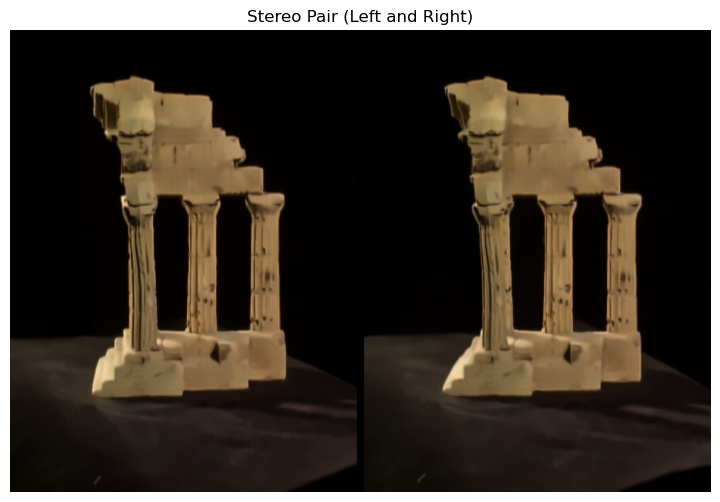

Fundamental Matrix (RANSAC):
 [[-8.83037002e-05 -7.71933225e-03  2.51775305e+00]
 [ 7.42298029e-03 -1.40092041e-04  1.00307070e+01]
 [-2.51385500e+00 -9.90138087e+00  1.00000000e+00]]


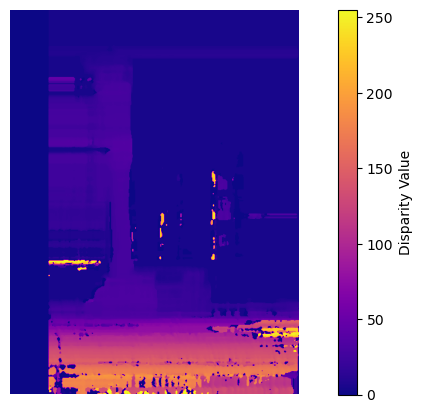

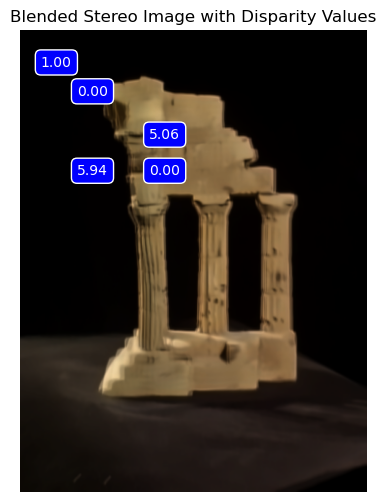

Number of 3D points: 123501
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
Screenshot saved to F:\Final Year Project\FYP-2\Tasks\6. 3D recinstruction via disperity map\6) 3D reconstruction via disparity\results\point_cloud_screenshot.png
Point cloud saved to F:\Final Year Project\FYP-2\Tasks\6. 3D recinstruction via disperity map\6) 3D reconstruction via disparity\results\point_cloud.ply


In [161]:
denoised_imgL = denoise_image(undistorted_left)
denoised_imgR = denoise_image(undistorted_right)
plot_images(denoised_imgL, denoised_imgR)

K = np.matrix('1520.40 0.00 302.32; 0.00 1525.90 246.87; 0.00 0.00 1.00')

E, R1, T1, R2, T2, P1, P2 = run_all(denoised_imgL, denoised_imgR, K)

image_size = (denoised_imgL.shape[1], denoised_imgL.shape[0])
T2 = np.array([0.6, 0.0, 0], dtype=np.float64)
# rectL, rectR, Q = rectify_monocular_stereo(denoised_imgL, denoised_imgR, K, dist, R2, T2, image_size)
# plot_rectified_images(rectL, rectR)

disparity_map = compute_disparity_map(denoised_imgL, denoised_imgR)

display_disparity_overlay(denoised_imgL, denoised_imgR, abs(disparity_map))
baseline=0.5
# Step 2: Reconstruct 3D points
points_3D, pixel_coords = reconstruct_3D_with_pixels((disparity_map), K, baseline)

print(f"Number of 3D points: {len(points_3D)}")
# Step 3: Visualize the point cloud with colors
# visualize_point_cloud(disparity_map,rectL, Q)

visualize_point_cloud(points_3D,denoised_imgL,disparity_map,K)